In [1]:
# Allow interactive plots
%matplotlib widget
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1' # This avoids crashes on the math cluster from using to many resources
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from scipy import stats
from matplotlib import animation
import copy
import sys



from os.path import exists

# insert at 1, 0 is the script path (or '' in REPL)
# sys.path.insert(1, '/home/marius/PhD/CellMotility/analysis/')
from analysis_library import *


In [2]:
parameterFile = "/home/marius/PhD/CellMotility/agent_simulation/output_delayed_CIL/RDF/A_0.3_Pe_120"

"""Reads a previously written file containing a multidimensional histogram. It assumes that the histogram is 
in the same folder as the parameterFile and is named parameterFile+"_histogram.csv"""
sim = experiment("sim")
sim.periodic = True
params = sim.read_parameter_file(parameterFile)
maxLength = sim.set_max_distance()

In [3]:

with open(parameterFile+"_histogram.csv", 'r') as f:
    csvFile = csv.reader(f, delimiter=" ")
    for line in csvFile:
        if(line[0]=="Frequency,"): continue
        elif(line[0]=="binWidths:"): #Initialise the histogram and parameters
            print(line)
            rBinWidth = float(line[1])
            phiRBinWidth = float(line[2])
            phi1BinWidth = float(line[3])
            phi2BinWidth = float(line[4])
            nTimes = float(line[5])
            nRBins = int(np.ceil(maxLength/rBinWidth)) #Only positive values
            nPhiRBins = int(np.ceil(2*np.pi/phiRBinWidth)) 
            nPhi1Bins = int(np.ceil(2*np.pi/phi1BinWidth)) 
            nPhi2Bins = int(np.ceil(2*np.pi/phi2BinWidth))
            histogram = np.zeros((nRBins, nPhiRBins, nPhi1Bins, nPhi2Bins, 3)) 

        else:
            if float(line[6]) == 0: #First time step only
                # Distance, angle between particles, velcity angle 1, velocity angle 2, typeIdx , timeIdx, time 
                # type has: 0 (both red), 1 (both green), 2 (green-red pair)S
                histogram[  int(float(line[1])), 
                            int(float(line[2])), 
                            int(float(line[3])),
                            int(float(line[4])),
                            int(line[5])] = int(float(line[0]))
            
cpy = histogram 
histogram.shape
histogram.min()
histogram.max()

['binWidths:', '0.5', '0.2617993877991494', '0.2617993877991494', '0.2617993877991494', '5', '']


22.0

In [4]:
histogram.shape
np.sum(histogram)

7998000.0

In [5]:
# Reference histogram
nReferencePoints = 6000
sim.periodic = True
referenceHistogram = sim.generate_reference_histogram(nReferencePoints,nRBins, nAngleBins = nPhiRBins)
referenceHistogram.min()
ref_cpy = referenceHistogram

In [6]:
histogram = cpy
referenceHistogram = ref_cpy
sim.periodic

True

In [7]:
# Marginalize the distribution (needs to go from last to first index)
# if(timeAvr==True):
#     histogram = np.sum(histogram, 5)
# if(pairType=="all"):
#     histogram = np.sum(histogram, 4)
# if(nPhi2Bins==1):
#     histogram = np.sum(histogram, 3)
# if(nPhi1Bins==1):
#     histogram = np.sum(histogram, 2)
# if(nPhiRBins==1):
#     histogram = np.sum(histogram, 1)

# Type: 0 - red&red 1 - green&green 2 - red&green

# histogram = histogram[:,:,:,0] #Select pair types
histogram = np.sum(histogram, 4) #Average over pair types
histogram = np.sum(histogram, 3) #Average over phi 2
histogram = np.sum(histogram, 2) #Average over phi 1
# histogram = np.sum(histogram, 2) #Average over phi R
histogram.shape


(89, 24)

In [8]:
# Create bin
rBins = np.linspace(0, maxLength, nRBins+1)[:-1] + rBinWidth #Center of each bin
phi1Bins = np.linspace(0, 2*np.pi, nPhiRBins+1)[:-1] + phi1BinWidth
referenceHistogram.max()
np.sum(histogram)

7998000.0

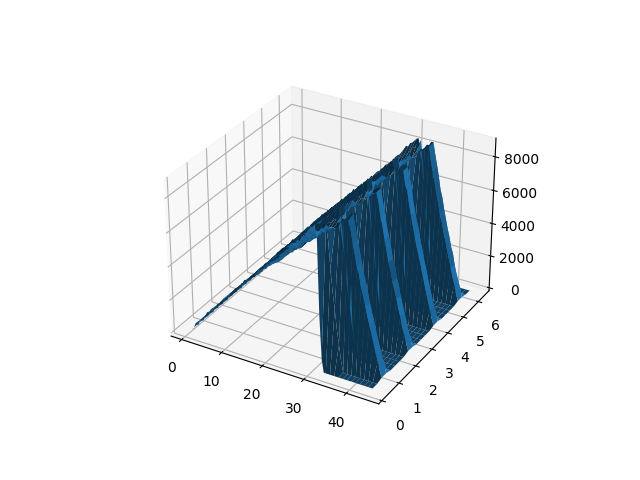

In [9]:
# Plot unnormalised densitites
fig3D = plt.figure()
ax3D = plt.axes(projection="3d")
X = np.outer(rBins, np.ones(1))
Y = np.outer(np.ones(1), phi1Bins)
ax3D.plot_surface(X, Y, histogram, label="reference")

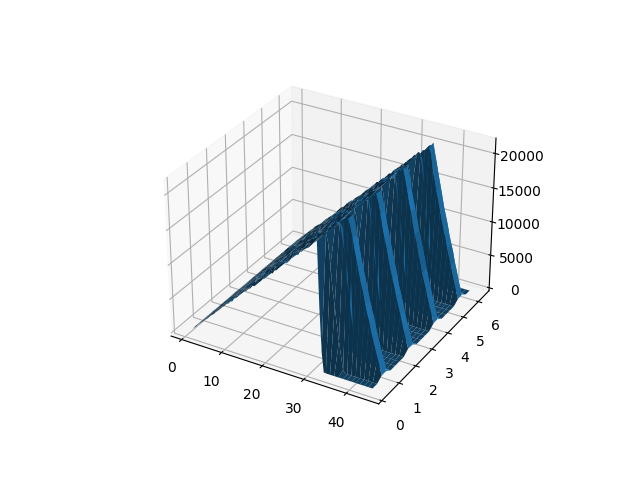

In [10]:
# Plot reference histogram
fig3D = plt.figure()
ax3D = plt.axes(projection="3d")
X = np.outer(rBins, np.ones(1))
Y = np.outer(np.ones(1), phi1Bins)
ax3D.plot_surface(X, Y, referenceHistogram, label="reference")

In [11]:
# Cutoff all values that are in the corners 
cutoff = int(maxLength/np.sqrt(2)/rBinWidth)
histogram = histogram[0:cutoff]
referenceHistogram = referenceHistogram[0:cutoff]

# Create bins
rBins = np.linspace(0, maxLength, cutoff+1)[:-1] + rBinWidth #Center of each bin
phi1Bins = np.linspace(0, 2*np.pi, nPhi1Bins+1)[:-1] + phi1BinWidth

In [12]:
# Normalise the radial and angular density
nReferenceValues = (nReferencePoints-1)*(nReferencePoints)/2
nValues = np.sum(histogram)
normalisedHistogram = histogram/referenceHistogram*nReferenceValues/nValues

In [13]:
histogram.shape
referenceHistogram.shape

(62, 24)

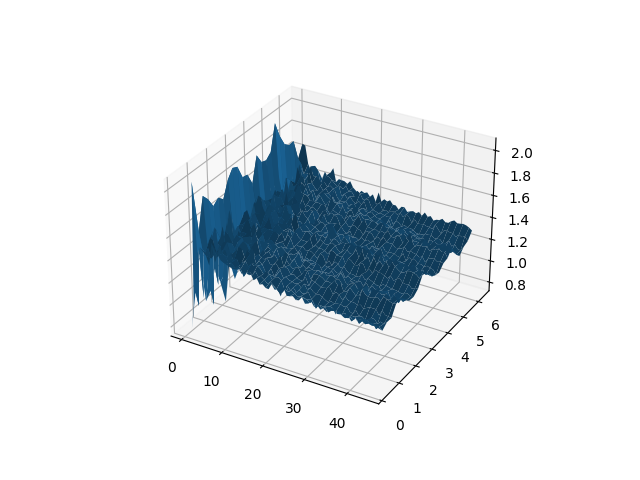

In [14]:
# Plot normalised densitites
fig3D = plt.figure()
ax3D = plt.axes(projection="3d")
X = np.outer(rBins, np.ones(1))
Y = np.outer(np.ones(1), phi1Bins)
ax3D.plot_surface(X, Y, normalisedHistogram, label="data")
fig3D.savefig(parameterFile+"_histogram_phiR_centered_measurement.pdf",dpi=500)

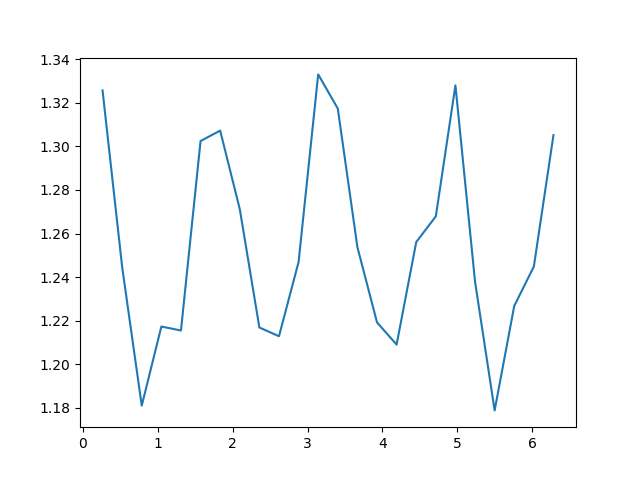

In [15]:
fig, ax = plt.subplots(1,1)
plt.plot(phi1Bins, normalisedHistogram[-1])

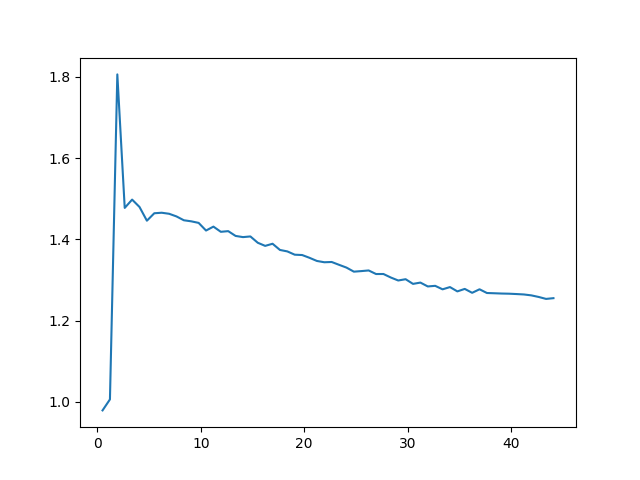

In [16]:
fig, ax = plt.subplots(1,1)
plt.plot(rBins,np.sum(histogram,1)/np.sum(referenceHistogram,1)*nReferenceValues/nValues)

In [17]:
plt.close("all")